In [173]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
import texcrapy
#from konlpy.corpus import word
from ckonlpy.tag import Twitter, Postprocessor
import json
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer, LTokenizer
from soynlp.noun import LRNounExtractor_v2
import nltk
from nltk import Text
from nltk.corpus import stopwords as STOPWORDS
from nltk.corpus import words as WORDS
import math
import os
import re

from gensim.models import Word2Vec, FastText
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

from wordcloud import WordCloud

sns.set(style='ticks')
rcParams['font.family'] = u'Malgun Gothic'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Scraping

In [175]:
df = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','kw_supporter','kw_supported','keywords']]; df
_or = lambda kw: ' OR '.join(['#' + k.strip() for k in kw.split(',')])

qry_base = {row.shortname:_or(row.keywords) for row in df.itertuples()}
supporters = df.shortname[df.kw_supporter==True]
qry_sup = ' OR '.join([qry_base[sup] for sup in supporters]); qry_sup
qry = {row.shortname: '(' + qry_base[row.shortname] + ') AND (' + qry_sup + ')' if row.kw_supported==True else qry_base[row.shortname] for row in df.itertuples()}

In [ ]:
%%time
what = ['id', 'timestamp', 'text']
texcrapy.scrap(qry, what=what, lang='ko', end='2019-01-31', download_to='scrapped/twitter')

# Making Corpus

In [280]:
def preproc(text, remove_url=True, remove_mention=True, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    #PTNS = '|'.join((LINEBREAK, RT, URL, HASHTAG, MENTION, EMOJI))
    
    #out = {}
    #text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), '', text.lower())
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    #set_trace()
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()



class JsonCorpus:
    def __init__(self, *fnames, textkey='text'):
        self.fnames = fnames
        self.textkey = textkey
        self.corpus = self._corpus()

    def _corpus(self):
        corpus = {}
        for fname in tqdm_notebook(self.fnames):
            with open(fname, encoding='UTF-8-sig') as f:
                js = json.load(f)
                topitem = next(iter(js))
                sents = set() #[]
                
                for doc in js[topitem]:
                    sents.add(preproc(doc[self.textkey]))
                    #sents.append(preproc(doc[self.textkey]))
                    
                corpus[topitem] = sents
                
        return corpus
                
    def __iter__(self):
        for sents in self.corpus.values():
            yield from sents

    def __len__(self):
        return sum([len(sents) for sents in self.corpus.values()])
    
    
class Tokens:
    def __init__(self, tagger, **corpora):
        self.tagger = tagger
        self.tokensdict = self._get_tokens(**corpora)
    
    def _get_tokens(self, **corpora):
        tokens = {}
        for item, corpus in tqdm_notebook(corpora.items()):
            tokens[item] = [
                [
                    #(tok[0].replace(' - ', ''), tok[1]) for tok in self.tagger.pos(corp)
                    tok[0].replace(' - ', '') for tok in self.tagger.pos(corp)
                ] 
                for corp in corpus
            ]
        return tokens
    
    
    def freq(self):
        return {
            item: Text(sum(toks, [])).vocab() 
            for item, toks in tqdm_notebook(self.tokensdict.items())
            if item not in ['ootd','fashion','category']
        }
                
    def __iter__(self):
        for toks in self.tokensdict.values():
            yield from toks
            
    def __len__(self):
        return sum([len(toks) for toks in self.tokensdict.values()])    

In [281]:
fnames = ['scrapped/twitter/' + fname for fname in os.listdir('scrapped/twitter')]
jcorpus = JsonCorpus(*fnames)

# Making Dictionary

### 1. From Scraping keywords

In [282]:
df_keywords = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')['keywords']
keywords = {w.strip() for w in ', '.join(df_keywords).split(',')}

### 2. Soynlp nouns

In [283]:
noun_extractor = LRNounExtractor_v2(verbose=True)
_soynouns = noun_extractor.train_extract(jcorpus)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 493329 from 297951 sents. mem=3.163 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=4452893, mem=3.533 Gb
[Noun Extractor] batch prediction was completed for 112092 words
[Noun Extractor] checked compounds. discovered 106546 compounds
[Noun Extractor] postprocessing detaching_features : 128390 -> 117173
[Noun Extractor] postprocessing ignore_features : 117173 -> 117064
[Noun Extractor] postprocessing ignore_NJ : 117064 -> 116600
[Noun Extractor] 116600 nouns (106546 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=3.740 Gb                    
[Noun Extractor] 74.05 % eojeols are covered


In [284]:
freq_atleast = 5
soynouns = {k for k,v in _soynouns.items() if v.frequency>=freq_atleast}
soyngrams = {v for k,v in noun_extractor._compounds_components.items() if k in soynouns}

### 3. Korean words

In [285]:
with open('dic_system.txt', encoding='UTF-8-sig') as f:
    lines = f.readlines()
    
kowords = set() #{tok.split('\t')[0] for tok in lines}

### 4. English words

In [286]:
enwords = set(WORDS.words())

### 5. Custom words

In [287]:
cwords = '''
    주구장창, 셀스타그램, literide, 재고정리, kids, 하지만, uhd, snsd, 빛내, 키네스, yoona, lahaina, 발휘, 윤아, 
    클락스, station, jeju, asap, 침대, fedex, usps, 초근접, 상상, 
'''

#     이벤트, 스포츠, 이투데이, 보좌진, 홍보수석, 체리핑, 체리핑크, 기업, 오니츠카, 오니츠카타이거, 
#     마일드세븐, 세븐일레븐, 1949년, 오니츠카기하치로, 운동화, 2013, 시세이도, 
#     농구화, 제조회사, 1977년, 깔맞춤, 황금비율, 
#     주행거리, 인스파이어, 구입, 오니츠카슬립온, 계속, 생각, 맥시코66, 마라톤화,  hajiwon, 
#     연예인, kimchiu, 다시한번, 마린시티, 참가신청, 완료, 제주도, 게이밍, 운동스타그램, 아름다운, 러닝화, 미션완료, 
#     크리스마스선물, 아이제아, 질주본능, 어짜피, 소유욕, 뽀대욕, 
#     1990년, 보라매공원, 이름값, 이성경, 디자인, 베이스볼, 스파이크, 한그루, 토리브엔터테인먼트, 다방구, 재밌는추억, 
#     패션쇼, 스키니진, 프로젝트, 의상학, tryout, 크리스마스, 얼스타그램, 셀스타그램, 콜라보, 
#     selfie, 아스크림, 들기름, 에어맥스, 2008, 뭐시기, 이미테이션, 게다가, 
#     우먼스, 하의실종, 준비물, 1994년, 패스트, 오프화이트, 인스타, 팬도럼, 


cwords = set(re.findall(r'[^ ,]+', re.sub(r'\n', '', cwords)))

### 4. Twitter dictionary

In [288]:
twitter = Twitter()
newwords = list(keywords | soynouns | kowords | enwords | cwords)
twitter.add_dictionary(newwords, 'Noun')

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


# Tagger setup

### 1. Passtags

In [289]:
stoptags = {'Foreign','Punctuation','KoreanParticle','Josa','Eomi','PreEomi','Exclamation','Determiner'}
passtags = set(twitter.tagset.keys()) - stoptags

### 2. Stopwords

In [290]:
stopwords_en = STOPWORDS.words('english')

with open('stopwords-ko.json', encoding='UTF-8-sig') as f:
    stopwords_ko = json.load(f)
    
stopwords_custom = '''
    엔, 줄, 내, 에는, 잖아요, 라는, 데, 는, 것은, 는, 인가요, 란, 말인가, 시, 은, 하네, 이나, 지, 있음, 수, 있는, 
    있으신가, 요, 그렇다면, 하고, 내는, 후, 생, 가거, 한, 하시겠어요, 만, 되네, 하려면, 하다, 랑, 하게, 근데, pic, 님의, 
    호, 하세요, 흑, 적인, 다욧, 니, 보니, 건, 다, 위해, 히, 께, 난, 해, 면서, 용, 보자, 가서, 하는, 중, 도, 
    잉, 인, 울, 하러가기, 인, 준, 든, 이셨으면, 와의, 
    드는, 되네요, 크흐, 이걸, 서, 에도, 됩니다, 하다고, 날, 
    하네요, 했습니다, 해지네요, 이였냐, 더, 
    되니, 하지않을, 아아, htm, 고, 냐고, 이야, 아니야, 너네, 된, 이냐, 해봐라, 해서, 
    vi, 
'''    

stopwords_custom = re.findall(r'[^ ,]+', re.sub(r'\n','',stopwords_custom))
stopwords = set(stopwords_en + stopwords_ko)# + stopwords_custom)

### 3. N-grams

In [291]:
cngrams = {
    ('캘빈','클라인'),('켈빈','클라인'),
}
#     ('the','boyz'),
#     ('어글리','슈즈'),
#     ('리미티드','에디션'),
#     ('키코','코스타디노브'), ('kiko','kostadinov'),
#     ('젤','카야노'),
#     ('젤','라이트'),('gel','lyte'),
#     ('스튜어트','와이츠먼'),
#     ('주니','블랙'),
#     ('jun','hyo','seong'),
#     ('gel','ptg'),
#     ('오니츠카','타이거'),
#     ('노박','조코비치'),
#     ('후디','티셔츠'),
#     ('최종병기','활'),
#     ('아이제아','토마스'),
#     ('gel','ace')
# ]

ngrams = list(cngrams | soyngrams)

In [292]:
tagger = Postprocessor(twitter, stopwords=stopwords, passtags=passtags, ngrams=ngrams)

In [293]:
tokens = Tokens(tagger, **jcorpus.corpus)

In [295]:
tokens.tokensdict['crocs'];

In [ ]:
newwords: 

In [296]:
tokensfreq = tokens.freq()

In [297]:
with open('model/tokensfreq.json', 'w', encoding='UTF-8-sig') as f:
    json.dump(tokensfreq, f, ensure_ascii=False)

In [299]:
tokensfreq;

# Word2vec

In [300]:
w2v = Word2Vec(tokens, size=100, window=5, min_count=10, workers=4, sg=1)
w2v.save('model/word2vec.model')

In [301]:
w2v.init_sims(replace=True)

In [302]:
w2v = Word2Vec.load('model/word2vec.model')

In [304]:
w2v.wv.most_similar(positive=['가성비'], topn=10)

[('성비', 0.7515897750854492),
 ('가격대비', 0.7347947359085083),
 ('성능', 0.6302908658981323),
 ('저렴이', 0.6245683431625366),
 ('최우수', 0.6229339838027954),
 ('보호대', 0.6150311231613159),
 ('실용성', 0.6097210049629211),
 ('인기템', 0.6085457801818848),
 ('pamu', 0.6070997714996338),
 ('이건사야', 0.6044137477874756)]

In [305]:
w2v.wv.similarity('무난','유니클로')

0.23139843984982017

In [306]:
id_pools = {
    '가성비': ['가성비','저렴','효율','성능','실용'], 
    '트렌디': ['유행','트렌드','trend','trendy'],#,'민감'],
    '신뢰성': ['신뢰','믿음','trust','견고','품질','안정','클래식','classic'],
    '럭셔리': ['럭셔리','고급','호화','luxury'], #,'품격'
    '유니크': ['유니크','독특','독창','unique','개성','only','참신','특이'],
    '활동성': ['활동','활발','운동','액티브','스포츠','active','sport','sports','sporty'],
    '과감함': ['과감','선도','선구','대담','강렬','선명','예술','art'],
    # 철학, 정통, 격식, 아이디어, 변화, 변동, 환상, 신상, 새로운, 튀는, 
}

In [307]:
#docs = sum(tokens_dict.values(), [])

In [308]:
dct = Dictionary(tokens)
dct.filter_extremes(no_below=20, no_above=0.2)
dct.compactify()

In [309]:
corp = {item:[dct.doc2bow(tok) for tok in toks] for item, toks in tqdm_notebook(tokens.tokensdict.items())}

In [310]:
model_tfidf = TfidfModel(sum(corp.values(),[]), id2word=dct)

In [311]:
wordlist = list(dct.values())
identities = list(id_pools.keys())
brands = list(tokens.tokensdict.keys())

In [312]:
sim_mat = np.zeros((len(identities),len(wordlist)))
for i, idty in enumerate(tqdm_notebook(identities)):
    for j, word in enumerate(wordlist):
        sims = []
        for w in id_pools[idty]:
            try:
                sims.append(w2v.wv.similarity(w, word))
            except:
                sims.append(0)
        sim_mat[i,j] = np.mean(sims)
        #sim_mat[i,j] = np.mean([w2v.wv.similarity(w, word) for w in id_pools[idty]])

In [313]:
sim_mat.shape

(7, 20489)

In [314]:
def get_brand_vecs(bname):
    brand_tfidf  = model_tfidf[corp[bname]]
    return np.vstack([sparse2full(c, len(dct)) for c in brand_tfidf]).mean(axis=0)

def plot_id(bname):
    val = sim_mat.dot(get_brand_vecs(bname))
    #val /= val.sum()
    pd.Series(val, index=identities).plot.barh()

In [315]:
id_dict = {}
for bname in brands:
    if bname not in ['ootd','fashion','category']:
        try:
            id_dict[bname] = sim_mat.dot(get_brand_vecs(bname))
        except:
            print(bname)

#id_dict = {
#    bname:sim_mat.dot(get_brand_vecs(bname)) 
#    for bname in tqdm_notebook(brands)
#    if bname not in ['ootd','fashion','category']
#}

advisoryboardcrystals
doublet
engineeredgarment
experthorror
goat
heliotemil
ignoredprayers
novacancyinn
onlineceramics
saterdaysnyc
someware
sssworldcorp
ystrdystmrrw


In [316]:
pd.DataFrame(id_dict, index=identities).to_pickle('model/id_dict.pkl')

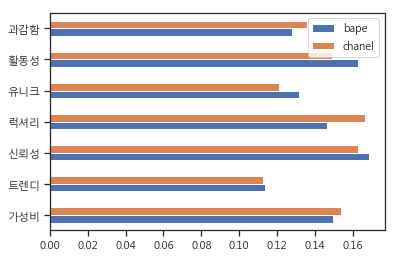

In [317]:
df = pd.read_pickle('model/id_dict.pkl')
df /= df.sum()
df[['bape','chanel']].plot.barh()

# 여기서 normalize 축을 바꾸면 어떨까?

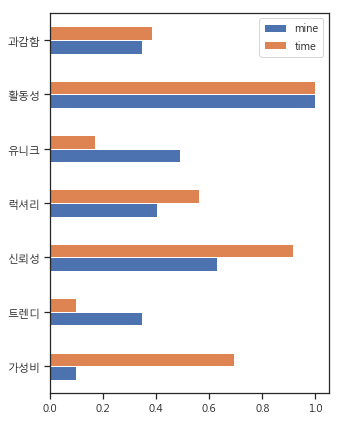

In [318]:
df = pd.read_pickle('model/id_dict.pkl')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(df)
df2 = df.copy()
df2[:] = X_train_minmax
df2[['mine','time']].plot.barh(figsize=(5,7))

In [ ]:
df2.T

In [319]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(df2.T)
# cluster = KMeans(n_clusters=10, random_state=0).fit(X_reduced)
# cluster = DBSCAN().fit(X_reduced)
cluster = AffinityPropagation().fit(X_reduced)
clustered = pd.Series(cluster.labels_, index=df2.columns); clustered

032c                     0
1017alyx9sm              1
8seconds                 3
99percentis             10
aape                     2
abecrombiefitch         19
acnestudios              0
acoldwall               16
acronym                  4
adererror               24
adidas                   4
adidasoriginal           1
aecawhite               16
aimeleondore            10
aldo                     3
alexandermcqueen        11
alexanderwang           16
allsaints                4
alphaindustry            4
ambush                  10
ami                     17
amiri                   23
antisocialsocialclub    13
apc                     17
arcteryx                 3
asics                    9
awakeny                 22
balenciaga              21
bally                   23
balmain                 23
                        ..
tomsshoes                8
topshop                 25
topten                   6
toryburch               23
tumi                    23
ugg                      8
u

In [320]:
clrd = pd.DataFrame(clustered.sort_values()).reset_index()
clrd.columns = ['bname', 'cluster']
clrd.to_excel('model/clustered.xlsx')

In [321]:
clrd[clrd.bname=='adidas']

,bname,cluster
62,adidas,4


In [322]:
clustered.index[clustered==9]

Index(['asics', 'descente', 'drmartens', 'eider', 'fila', 'giordano',
       'jansport', 'kangol', 'kolonsport', 'lafuma', 'lmc', 'nepa',
       'newbalance', 'prospecs'],
      dtype='object')

In [323]:
df2.loc['신뢰성']

032c                    0.921131
1017alyx9sm             1.000000
8seconds                0.894010
99percentis             0.773222
aape                    0.975499
abecrombiefitch         0.844910
acnestudios             1.000000
acoldwall               1.000000
acronym                 1.000000
adererror               1.000000
adidas                  0.907210
adidasoriginal          1.000000
aecawhite               1.000000
aimeleondore            0.809190
aldo                    1.000000
alexandermcqueen        1.000000
alexanderwang           1.000000
allsaints               1.000000
alphaindustry           0.916350
ambush                  0.815106
ami                     0.947703
amiri                   0.979774
antisocialsocialclub    0.971174
apc                     0.955957
arcteryx                0.983103
asics                   0.862977
awakeny                 0.987181
balenciaga              1.000000
bally                   0.899009
balmain                 0.930140
          

In [325]:
df_kw = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','keywords']].set_index('shortname')
df_kw;

In [326]:
def plot_wc(bname):
    with open('model/tokensfreq.json', encoding='UTF-8-sig') as f:
        j = json.load(f)[bname]
        kws = [kw.strip() for kw in df_kw.keywords.loc[bname].split(',')]
        [j.pop(kw, None) for kw in kws]

    x,y = np.ogrid[:300, :300]
    mask = (x-150)**2 + (y-150)**2 > 130**2
    mask = 255 * mask.astype(int)
        
    font_path = r'c:\Windows\Fonts\NanumBarunGothic.ttf'
    wc = WordCloud(width=100, height=100, background_color='white', font_path=font_path, random_state=0, mask=mask)
    
    try:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(wc.generate_from_frequencies(j), interpolation='bilinear')
        ax.axis('off')
        fig.savefig('model/wordcloud/wc_' + bname + '.png', format='png')
        
    except:
        print(bname)
        
    finally:
        plt.close(fig)

In [327]:
for row in tqdm_notebook(df_kw.itertuples()):
    bname = row.Index
    
    fname = 'model/wordcloud/wc_' + bname + '.png'
    if os.path.isfile(fname):
        continue
        
    if bname not in ['ootd','fashion','category']:
        plot_wc(bname)

doublet
engineeredgarment
ignoredprayers
saterdaysnyc
advisoryboardcrystals
experthorror
goat
heliotemil
novacancyinn
onlineceramics
someware
sssworldcorp
ystrdystmrrw
